# Imports


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yaml
import sys
import os
import re
import json
from tqdm import tqdm
import warnings

from pyspark.sql import functions as F
from pyspark.sql.types import DateType, ArrayType, StringType
from pyspark.sql.functions import udf, broadcast


#from optbinning import OptimalBinning, ContinuousOptimalBinning
import category_encoders as ce
from typing import List, Dict
import shap
import lightgbm as lgb
import scipy
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import joblib

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, brier_score_loss

import lime
import lime.lime_tabular
from pathlib import Path

In [2]:
# paths and custom modules
cwd_path = Path(os.getcwd())
data_path = cwd_path/'data/'
objects_path = cwd_path/'objects/'
sys.path.append(os.path.dirname(cwd_path))

from utils import *

data_catalog, models_catalog = return_catalog()

In [3]:
# set the pyspark path to env excutable
conda_env_path = sys.prefix
os.environ['PYSPARK_PYTHON'] = os.path.join(conda_env_path, 'python')

# build spark session
spark = build_spark_session()
spark

# 2- Fetch


In [4]:
# fetch data
data_date = '20240810'
income_model_version = 'v0.7'
# processed all features
df_to_all_models = pd.read_parquet(data_path/f"features_store/{data_date}_L1_processed_features.parquet")

# income predictions
income_predics = pd.read_parquet(data_path/f'models_preds/{data_date}_income_{income_model_version}_predics.parquet')
income_predics = income_predics.rename(columns={'predics': 'income_predics'})

pd_raw_df = df_to_all_models.merge(
    income_predics,
    how='left',
    on='client_id',
    )

# 3- Select Features


In [5]:
## Selecting features that will be consumed by the pd model (FS 8th-variation)
## Updated after second iteration of income model

pd_raw_df = pd_raw_df[[
    'client_id',
    # 'ssn',
    # 'phone_number_1',
    # 'phone_number_2',
    # 'flag_is_mc_customer',
    'flag_is_prv_cash_trx',
    # 'flag_is_rescore',
    #'job_name',
    'job_name_map',
    #'job_type',
    # 'insurance_type',
    'marital_status',
    'children_count',
    'address_governorate',
    'address_city',
    'address_area',
    'house_type',
    #'mobile_os_type',
    #'days_since_contract',
    'have_car',
    'car_model_category',
    'have_club_id',
    'ssn_is_male',
    'ssn_governorate',
    'age_at_contract',
    #'net_income_first',
    # 'net_income',
    # 'net_burden',
    
    'net_income_inflated',
    'income_predics', # data from income model
    #'net_burden_inflated',
    # 'is_net_income_inflated_in_range', #proxy feature
    #'ss_min_income',
    #'ss_max_income',
    'is_iscore',
    'iscore_score',
    # 'is_iscore_new_format',
    'OpenAccounts_count',
    'OpenAccounts_ApprovalAmount_sum',
    #'OpenAccounts_ApprovalAmount_sum_pofi',
    'OpenAccounts_BalanceAmount_sum',
    #'OpenAccounts_BalanceAmount_sum_pofi',
    'OpenAccounts_InstallmentAmount_sum',
    #'OpenAccounts_InstallmentAmount_sum_pofi',
    'OpenAccounts_MaxDaysDue_sum',
    'ClosedAccounts_count',
    'ClosedAccounts_ApprovalAmount_sum',
    #'ClosedAccounts_ApprovalAmount_sum_pofi',
    'ClosedAccounts_InstallmentAmount_sum',
    #'ClosedAccounts_InstallmentAmount_sum_pofi',
    'ClosedAccounts_MaxDaysDue_sum',
    # 'days_from_first_trx',
    # 'days_from_last_trx',
    # 'n_trx_online',
    # 'n_trx_branch',
    # 'net_sales_pos',
    # 'net_sales_pos_pofi',
    # 'net_sales_neg',
    # 'net_sales_neg_pofi',
    # 'net_qty_pos',
    # 'net_qty_neg',
    #'first_ord_dbr',
    #'first_ord_tenor',
    'fo_par90_flag',
    'job_map_max_salary'
    ]].copy()

## proxy feature
#pd_raw_df['income_ratio'] = pd_raw_df['net_income_inflated'] / pd_raw_df['income_predics'] - 1

In [6]:
# Apply final income logic
pd_raw_df['final_income'], _ = calculate_income_zones(pd_raw_df,
                                                      'net_income_inflated',
                                                      'income_predics',
                                                      blogic='all_not_verify')

pd_raw_df = pd_raw_df.drop(columns=['net_income_inflated'])
pd_raw_df = pd_raw_df.drop(columns=['income_predics'])

# 4- TTS

In [7]:
# save identifier
client_id = 'client_id'
# select target
target = 'target'
pd_raw_df = pd_raw_df.rename(columns={'fo_par90_flag': 'target'})

# split data into train and test sets
X = pd_raw_df.drop([target, client_id], axis=1)
y = pd_raw_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# create full_train and full_test dataframes
full_train = pd.concat([pd_raw_df.loc[X_train.index, client_id], X_train, y_train], axis=1)
full_test = pd.concat([pd_raw_df.loc[X_test.index, client_id], X_test, y_test], axis=1)

print(full_train.shape, full_test.shape, full_train[target].mean(), full_test[target].mean())

# copy before transformations
full_train_org = full_train.copy()
full_test_org = full_test.copy()

(634852, 29) (158713, 29) 0.06922715845582908 0.0688664444626464


# 5- Transformations

In [8]:
# copy before transformations
full_train = full_train_org.copy()
full_test = full_test_org.copy()
#
numerical_cols = get_cols_by_type(X_train, 'numerical')

cat_cols = get_cols_by_type(X_train, 'categorical')

columns_to_trans_woe = ['job_name_map', 'address_governorateee', 'address_city',
                        'address_area', 'ssn_governorateee']
columns_to_trans_oh = ['marital_status', 'job_type',
                        'house_type', 'car_model_category']

In [9]:
print(full_train.shape)
print(full_test.shape)

(634852, 29)
(158713, 29)


### WOE Transformation

In [10]:
# # Initialize
# woe_transformer = WoeTransformer(target_type='continuous', min_bin_size=0.01)
# # Fit
# woe_transformer.fit(full_train_org, target=target, columns_categorical=columns_to_trans_woe)
# # Transform
# full_train = woe_transformer.transform(full_train_org.copy(), ignore_na=True,
#                                        remove_original=True)
# full_test = woe_transformer.transform(full_test_org.copy(), ignore_na=True,
#                                       remove_original=True)
# # check
# print(full_train.shape)
# print(full_test.shape)

### One-Hot Encoding

In [11]:
# # Initialize
# one_hot_encoder = OneHotEncoderCustom()
# # Fit
# one_hot_encoder.fit(full_train.copy(), columns_categorical=columns_to_trans_oh)
# # Transform
# full_train = one_hot_encoder.transform(full_train.copy(), ignore_na=True, remove_original=True)
# full_test = one_hot_encoder.transform(full_test.copy(), ignore_na=True, remove_original=True)
# # check
# print(full_train.shape)
# print(full_test.shape)

# 6- Feature Engineering

### Analyze

In [12]:
stats_results = stat_analyze_features(full_train.drop(columns=['client_id']).copy(),
                                         target, 
                                         features=numerical_cols)
stats_results.reset_index(drop=True)

  0%|          | 0/19 [00:00<?, ?it/s]c:\Users\amr.tawfik\Documents\GitHub\mylo\components\risk-engine\notebooks\utils.py:252: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(feature_data[target], feature_data[feature])
c:\Users\amr.tawfik\Documents\GitHub\mylo\components\risk-engine\notebooks\utils.py:253: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(feature_data[target], feature_data[feature])
100%|██████████| 19/19 [00:01<00:00,  9.75it/s]


,feature,share_na,spearman_corr,pearson_corr,kendall_corr,mean,std,min,25%,50%,75%,max
0,OpenAccounts_InstallmentAmount_sum,0.843266,0.120751,0.008623,0.104281,2071.245361,1.210723e+04,0.0,0.0,668.0,1903.000,1.660374e+06
1,OpenAccounts_BalanceAmount_sum,0.843266,0.109273,0.004082,0.090828,82205.515625,1.019320e+06,-17020.0,960.5,21827.0,91058.000,2.988335e+08
2,OpenAccounts_count,0.843266,0.103984,0.096972,0.095784,1.469353,1.326463e+00,0.0,1.0,1.0,2.000,5.800000e+01
3,ClosedAccounts_InstallmentAmount_sum,0.843266,0.098055,0.002890,0.095825,305.324310,1.007346e+04,0.0,0.0,0.0,0.000,2.516512e+06
4,ClosedAccounts_count,0.843266,0.087697,0.090989,0.086481,0.225410,5.806823e-01,0.0,0.0,0.0,0.000,2.500000e+01
5,ClosedAccounts_ApprovalAmount_sum,0.843266,0.084358,0.007366,0.080716,11853.697266,1.811338e+05,0.0,0.0,0.0,0.000,5.120069e+07
6,OpenAccounts_ApprovalAmount_sum,0.843266,0.072100,0.001004,0.059562,100787.945312,1.071011e+06,0.0,7950.0,39000.0,109313.500,3.063764e+08
7,is_iscore,0.000000,0.060077,0.060077,0.060077,0.156734,3.635502e-01,0.0,0.0,0.0,0.000,1.000000e+00
8,ssn_is_male,0.000000,0.042286,0.042286,0.042286,0.686250,4.640166e-01,0.0,0.0,1.0,1.000,1.000000e+00
9,ClosedAccounts_MaxDaysDue_sum,0.843266,0.032491,0.012053,0.032208,2.959529,4.134673e+01,0.0,0.0,0.0,0.000,4.347000e+03


### Select

In [13]:
#to_model_features = stats_results.loc[abs(stats_results['spearman_corr']) > 0.07, 'feature'].to_list()
to_model_features = numerical_cols + cat_cols

full_train = full_train[[client_id]+ to_model_features + [target]]
full_test = full_test[[client_id]+ to_model_features + [target]]
X_train = full_train[to_model_features]
X_test = full_test[to_model_features]
y_train = full_train[target]
y_test = full_test[target]

### EOD Process

In [14]:
full_train = convert_dtypes_std(full_train.copy())
full_test = convert_dtypes_std(full_test.copy())
X_train = convert_dtypes_std(X_train.copy())
X_test = convert_dtypes_std(X_test.copy())

In [15]:
for col in cat_cols:
    full_train[col] = full_train[col].astype('category')
    full_test[col] = full_test[col].astype('category')
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# 7- Main Model Build

### Train-CV

In [16]:
learning_rate = 0.01

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'importance_type': 'gain',
    'n_estimators': 500,
    'learning_rate': learning_rate,
    'num_leaves': 2**5,
    'colsample_bytree': 0.4,
    'subsample': 0.25,
    'subsample_freq': 1,
    'min_child_samples': 50,
    'reg_alpha': 1.1,
    'bagging_seed': 42,
    'random_state': 42,
    'force_row_wise': True,
    }

n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store scores
best_valid_score = 0
best_model_lgb = None

oof = np.zeros(len(X_train))
train_scores = []
valid_scores = []

for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    model_lgb = lgb.LGBMClassifier(**lgb_params)

    model_lgb.fit(
        X_train_fold, y_train_fold,
        feature_name=numerical_cols+cat_cols,
        categorical_feature=cat_cols,
        eval_set=[(X_train_fold, y_train_fold), (X_valid_fold, y_valid_fold)],
        eval_metric=lgb_params['metric'],
    )

    oof[valid_index] = model_lgb.predict_proba(X_valid_fold, num_iteration=model_lgb.best_iteration_)[:, 1]

    train_score = roc_auc_score(y_train_fold, model_lgb.predict_proba(X_train_fold, num_iteration=model_lgb.best_iteration_)[:, 1])
    valid_score = roc_auc_score(y_valid_fold, model_lgb.predict_proba(X_valid_fold, num_iteration=model_lgb.best_iteration_)[:, 1])
    train_scores.append(train_score)
    valid_scores.append(valid_score)

    print(f"Fold {fold + 1} Training AUC: {train_score}, Validation AUC: {valid_score}")
    
    # Update best calibrated model if this one is better
    if valid_score > best_valid_score:
        best_valid_score = valid_score
        best_model_lgb = model_lgb

print(f"Average Training AUC: {np.mean(train_scores)}")
print(f"Average Validation AUC: {np.mean(valid_scores)}")

Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 29425, number of negative: 393809
[LightGBM] [Info] Total Bins 4993
[LightGBM] [Info] Number of data points in the train set: 423234, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069524 -> initscore=-2.594021
[LightGBM] [Info] Start training from score -2.594021
Fold 1 Training AUC: 0.8672877528644585, Validation AUC: 0.8577560216958745
Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 29380, number of negative: 393855
[LightGBM] [Info] Total Bins 4984
[LightGB

### Hyperparameter Tunning

### Metrics & Analysis

In [17]:
full_test_neutral = full_test.copy()
full_test_neutral['first_ord_dbr'] = np.NaN
full_test_neutral['first_ord_tenor'] = np.NaN
X_test_neutral = X_test.copy()
X_test_neutral['first_ord_dbr'] = np.NaN
X_test_neutral['first_ord_tenor'] = np.NaN

In [18]:
#predictions
full_train['predics'] = best_model_lgb.predict_proba(X_train)[:, 1]
full_test['predics'] = best_model_lgb.predict_proba(X_test)[:, 1]
#full_test_neutral['predics'] = model_lgb.predict_proba(X_test_neutral)[:, 1]

In [19]:
print('Gini Train: ', calc_gini(y_train, full_train['predics']).round(3))
print('Gini Test: ', calc_gini(y_test, full_test['predics']).round(3))
#print('Gini Neutral Test: ', calc_gini(y_test, full_test_neutral['predics']).round(3))

Gini Train:  0.729
Gini Test:  0.72


c:\Users\amr.tawfik\Documents\GitHub\mylo\components\risk-engine\notebooks\utils.py:823: RuntimeWarning: invalid value encountered in subtract
  np.abs(thresholds_test - selected_records[i]).argmin()


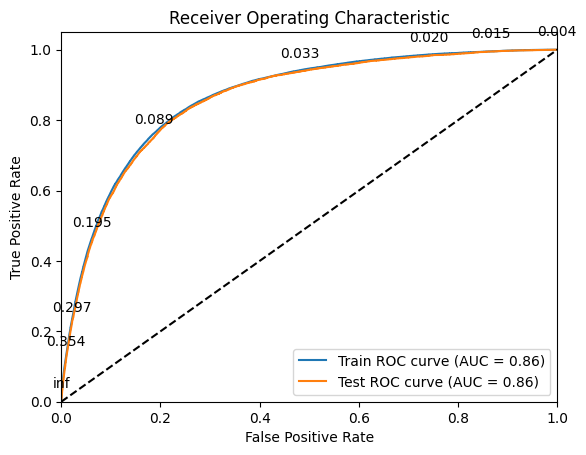

In [20]:
get_roc(y_train, full_train['predics'], y_test, full_test['predics'])
#get_roc(y_train, full_train['predics'], y_test, full_test_neutral['predics'])

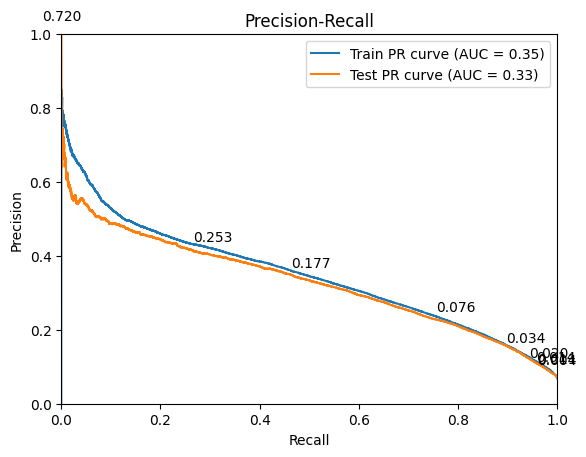

In [21]:
get_PR(y_train, full_train['predics'], y_test, full_test['predics'])
# get_PR(y_train, full_train['predics'], y_test, full_test_neutral['predics'])

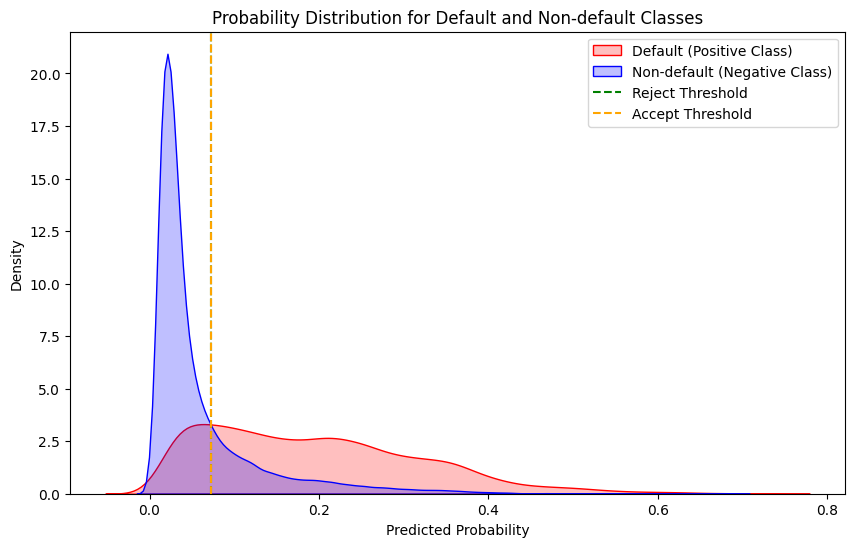

In [22]:
plot_probability_distribution(y_test, full_test['predics'], 0.073, 0.073)
# plot_probability_distribution(y_test, full_test_neutral['predics'], 0.06, 0.04)

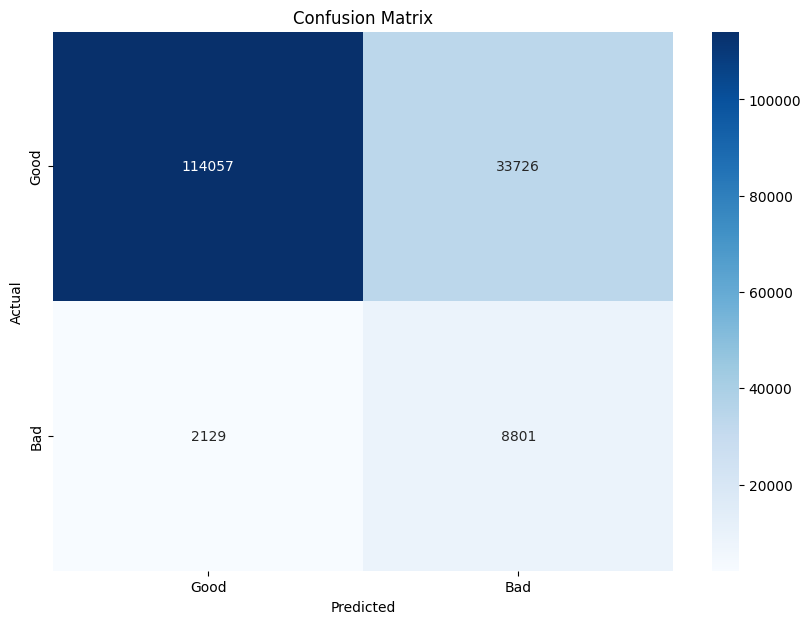

Precision: 20.70%
Recall: 80.52%
Approval rate: 73.21%


In [23]:
calc_class_metrics_iv(y_test, full_test['predics'], score_cutoff=0.073, normalize=False)
#calc_class_metrics_iv(y_test, full_test_neutral['predics'], score_cutoff=0.025, normalize=False)

In [24]:
def get_class_SHAP(model: object, X_train: pd.DataFrame, feature_no_disp: int = 30) -> pd.DataFrame:
    # SHAP summary Plot
    X_train = X_train.copy()
    x_sample = X_train.sample(int(0.1 * len(X_train)))
    shap_values = shap.TreeExplainer(model).shap_values(x_sample)
    # For binary classification, select the SHAP values for the positive class
    shap_values = shap_values[1]
    shap.summary_plot(shap_values, x_sample, max_display=feature_no_disp, show=False)
    # SHAP importance
    shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
    vals = np.abs(shap_df.values).mean(0)
    shap_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=["feature", "feature_importance_vals"])
    shap_importance = shap_importance.sort_values(by=["feature_importance_vals"], ascending=False)
    display(shap_importance.head(feature_no_disp))

In [25]:
def get_class_SHAP(model, X_train, feature_no_disp):
    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # For binary classification, select the SHAP values for the positive class
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]
    
    # Ensure shap_values is a 2D array
    if len(shap_values.shape) == 1:
        shap_values = shap_values.reshape(-1, 1)
    
    # Plot summary
    shap.summary_plot(shap_values, X_train, max_display=feature_no_disp, show=False)
    
    # SHAP importance
    shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
    return shap_df

c:\Users\amr.tawfik\Documents\GitHub\mylo\components\risk-engine\venv-risk\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


,flag_is_prv_cash_trx,children_count,have_car,have_club_id,ssn_is_male,age_at_contract,is_iscore,iscore_score,OpenAccounts_count,OpenAccounts_ApprovalAmount_sum,...,job_map_max_salary,final_income,job_name_map,marital_status,address_governorate,address_city,address_area,house_type,car_model_category,ssn_governorate
0,0.0,-0.017725,0.000101,0.000067,0.056296,0.266639,0.000007,0.008643,0.000339,0.002933,...,0.196014,0.618244,0.381574,-0.014496,0.176754,0.234721,0.086063,0.092294,0.000398,-0.193187
1,0.0,-0.030854,0.000134,0.000078,-0.143643,0.111054,-0.000043,-0.256956,-0.001525,0.050343,...,-0.009772,-0.336533,-0.246296,-0.012832,0.023150,0.057438,0.105865,-0.072962,0.000486,-0.002094
2,0.0,-0.027924,0.000283,0.000067,-0.114877,0.001272,0.000003,-0.018538,-0.002492,0.001120,...,0.002091,-1.258221,-0.277561,0.064889,0.010178,0.126961,0.169858,-0.046091,0.000507,-0.119313
3,0.0,-0.002152,0.000410,0.000046,-0.119678,0.129082,0.000004,-0.017161,-0.001201,0.000641,...,0.001505,-0.002798,0.104072,-0.014528,-0.004741,0.164313,-0.003246,-0.051808,0.000767,0.074364
4,0.0,0.001452,0.000536,0.000081,0.042472,0.012074,0.000007,-0.013679,-0.000924,0.001973,...,0.033267,-0.816196,0.036594,-0.015937,-0.008292,0.167389,-0.259339,-0.050463,0.000838,0.062108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634847,0.0,0.028945,0.000458,-0.000004,0.042914,0.059528,0.000007,-0.014122,-0.000304,-0.003221,...,0.035391,-0.730929,0.046019,-0.016398,-0.027639,0.170702,0.500959,-0.052931,0.000885,0.075986
634848,0.0,-0.023579,-0.000218,-0.000004,0.048685,0.091017,0.000007,-0.022990,-0.001796,-0.001896,...,-0.017349,-0.261040,-0.188288,-0.018329,-0.047843,-0.152084,0.221635,-0.069109,0.000419,-0.104897
634849,0.0,-0.025791,0.000268,0.000108,0.089352,0.149067,0.000007,0.002572,-0.000147,0.005123,...,0.036451,-0.031471,0.045862,-0.011938,0.186511,0.249418,0.068329,0.259387,0.000484,-0.080468
634850,0.0,0.033168,0.000401,0.000038,0.022167,-0.233053,0.000007,-0.021436,-0.000865,-0.002591,...,-0.048774,-0.020986,-0.112468,-0.019741,-0.116697,0.020502,-0.122534,-0.050556,0.000555,-0.074767


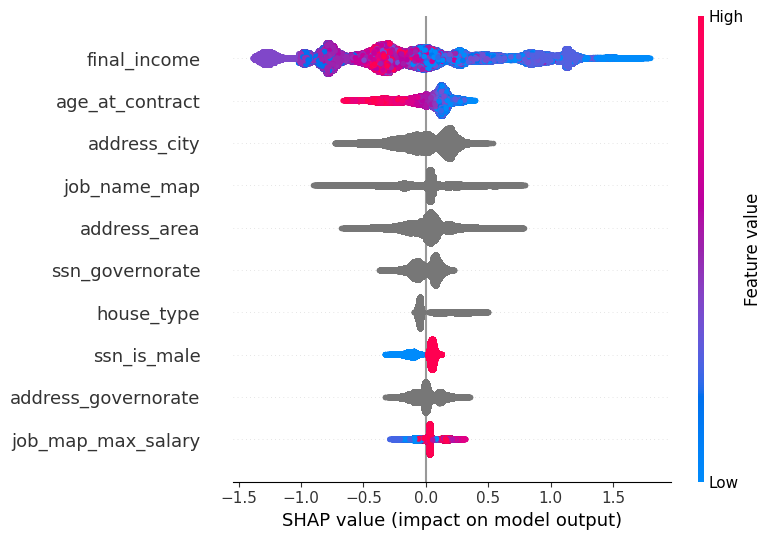

In [26]:
# Plotting feature importance and SHAP values
get_class_SHAP(
    model=model_lgb,
    X_train=X_train,
    feature_no_disp=10,
)

In [27]:
feature_importances = model_lgb.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

                                 Feature     Importance
18                          final_income  314826.672064
23                          address_area   94688.440239
19                          job_name_map   70310.859471
22                          address_city   64166.805745
5                        age_at_contract   41916.543254
17                    job_map_max_salary   41764.243138
7                           iscore_score   33493.618246
21                   address_governorate   23100.659959
26                       ssn_governorate   20913.889794
10        OpenAccounts_BalanceAmount_sum   16600.682520
11    OpenAccounts_InstallmentAmount_sum   14815.727915
24                            house_type   11784.741465
9        OpenAccounts_ApprovalAmount_sum    9676.524605
4                            ssn_is_male    7816.307858
1                         children_count    5209.892298
12           OpenAccounts_MaxDaysDue_sum    4603.082882
14     ClosedAccounts_ApprovalAmount_sum    3767

### Explainers

In [28]:
def expl_pd_model_output(explainer, data_instance, plot=False):
    """
    Generates a DataFrame explaining SHAP values for a single instance in terms of probability of default (PD)
    and optionally prints the SHAP waterfall plot.

    Args:
        explainer (shap.TreeExplainer): The SHAP explainer object.
        data_instance (pd.DataFrame): A single row DataFrame containing the features for the prediction.
        plot (bool): If True, displays the SHAP waterfall plot. Default is False.

    Returns:
        pd.DataFrame: A DataFrame containing the feature names, values, SHAP contributions, and a simple explanation.

    Raises:
        ValueError: If the provided data_instance does not have exactly one row.
    """
    # Check if the data_instance has exactly one row
    if data_instance.shape[0] != 1:
        raise ValueError(f"Expected data_instance to have exactly 1 row, but got {data_instance.shape[0]} rows.")
    
    # Get SHAP values for the data instance
    shap_values = explainer(data_instance)

    # Optionally plot the waterfall plot
    if plot:
        shap.waterfall_plot(shap_values[0])

    # Extract the feature names, values, and SHAP values (log-odds contributions)
    shap_contributions = pd.DataFrame({
        'Feature Name': data_instance.columns,
        'Feature Value': data_instance.values[0],
        'Contribution to Prediction': shap_values.values[0]
    })

    # Base value (average model prediction) and total prediction
    base_value = shap_values.base_values[0] if isinstance(shap_values.base_values, np.ndarray) else shap_values.base_values
    total_prediction = base_value + shap_contributions['Contribution to Prediction'].sum()

    # Calculate the sum of absolute SHAP values (contributions) for relative impact calculation
    abs_shap_sum = shap_contributions['Contribution to Prediction'].abs().sum()

    # Calculate relative impact percentage of each feature
    shap_contributions['Relative Impact (%)'] = (shap_contributions['Contribution to Prediction'].abs() / abs_shap_sum) * 100

    # Simple explanation based on SHAP value sign (positive or negative)
    def simple_explanation(shap_value):
        return "Increases PD" if shap_value > 0 else "Decreases PD"

    # Adding a simple 'Explanation' column
    shap_contributions['Explanation'] = shap_contributions['Contribution to Prediction'].apply(simple_explanation)

    # Sorting the DataFrame by absolute contribution to see the most impactful features first
    shap_contributions = shap_contributions.reindex(shap_contributions['Contribution to Prediction'].abs().sort_values(ascending=False).index)

    return shap_contributions

In [29]:
# Usage example:
# - Lower log-odds (more negative): Lower PD (lower risk of default).
# - Higher log-odds (closer to zero or positive): Higher PD (higher risk of default).
pd_explainer = shap.TreeExplainer(model_lgb)
single_instance_df = X_train.iloc[[0]] 
explained = expl_pd_model_output(pd_explainer, single_instance_df, plot=False)
explained

,Feature Name,Feature Value,Contribution to Prediction,Relative Impact (%),Explanation
18,final_income,6948.7,0.618244,26.145879,Increases PD
19,job_name_map,other-freelancer,0.381574,16.136947,Increases PD
5,age_at_contract,34,0.266639,11.276306,Increases PD
22,address_city,NaN,0.234721,9.926472,Increases PD
17,job_map_max_salary,16667.0,0.196014,8.289551,Increases PD
26,ssn_governorate,alexandria,-0.193187,8.169976,Decreases PD
21,address_governorate,NaN,0.176754,7.475021,Increases PD
24,house_type,old-rent,0.092294,3.903172,Increases PD
23,address_area,NaN,0.086063,3.639648,Increases PD
4,ssn_is_male,1,0.056296,2.380781,Increases PD


# Test Section

In [30]:
# from venn_abers import VennAbersCalibrator

# # Initialize cross-validation
# n_splits = 5  # Adjust as needed
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize arrays to store scores
# best_calibration_auc = 0
# best_calibration_brier = float('inf')
# best_cali_vac = None

# # Perform cross-validation for calibration
# for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
#     print(f"Fold {fold + 1}")
#     X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
#     y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

#     # Initialize Venn-Abers calibrator
#     vac = VennAbersCalibrator(estimator=best_model_lgb, inductive=False, n_splits=5)
#     vac.fit(X_train_fold, y_train_fold)
    
#     # Predict probabilities
#     prob_pos = vac.predict_proba(X_valid_fold)[:, 1]
    
#     # Calculate AUC-ROC score for calibration
#     calibration_auc = roc_auc_score(y_valid_fold, prob_pos)
    
#     # Calculate Brier score
#     brier_score = brier_score_loss(y_valid_fold, prob_pos)

#     print(f"Fold {fold + 1} Calibration AUC: {calibration_auc}, Brier Score: {brier_score}")

#     # Update best calibrated model if this one is better
#     if calibration_auc > best_calibration_auc or (calibration_auc == best_calibration_auc and brier_score < best_calibration_brier):
#         best_calibration_auc = calibration_auc
#         best_calibration_brier = brier_score
#         best_cali_vac = vac

# print(f"Best Calibration AUC: {best_calibration_auc}, Best Brier Score: {best_calibration_brier}")

# # Applying the best calibration model on full train and test sets
# full_train['cali_predics'] = best_cali_vac.predict_proba(X_train)[:, 1]
# full_test['cali_predics'] = best_cali_vac.predict_proba(X_test)[:, 1]

# # Further metrics and plots remain similar, just updated with the new calibrated predictions


# 8- Score Calibration

In [31]:
# Initialize cross-validation
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store scores
best_calibration_auc = 0
best_calibration_brier = float('inf')
best_cali_lgb = None

# Perform cross-validation for calibration
for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Calibrate the model
    cali_lgb = CalibratedClassifierCV(estimator=best_model_lgb, method='isotonic', cv='prefit')
    cali_lgb.fit(X_valid_fold, y_valid_fold)

    # Predict probabilities
    prob_pos = cali_lgb.predict_proba(X_valid_fold)[:, 1]

    # Calculate AUC-ROC score for calibration
    calibration_auc = roc_auc_score(y_valid_fold, prob_pos)
    
    # Calculate Brier score
    brier_score = brier_score_loss(y_valid_fold, prob_pos)

    print(f"Fold {fold + 1} Calibration AUC: {calibration_auc}, Brier Score: {brier_score}")

    # Update best calibrated model if this one is better
    if calibration_auc > best_calibration_auc or (calibration_auc == best_calibration_auc and brier_score < best_calibration_brier):
        best_calibration_auc = calibration_auc
        best_calibration_brier = brier_score
        best_cali_lgb = cali_lgb

print(f"Best Calibration AUC: {best_calibration_auc}, Best Brier Score: {best_calibration_brier}")

Fold 1
Fold 1 Calibration AUC: 0.8688661498753981, Brier Score: 0.05204116787814061
Fold 2
Fold 2 Calibration AUC: 0.8588821868769166, Brier Score: 0.05319569256699601
Fold 3
Fold 3 Calibration AUC: 0.86729069334961, Brier Score: 0.05305481112891205
Best Calibration AUC: 0.8688661498753981, Best Brier Score: 0.05204116787814061


In [32]:
# full_test_neutral = full_test.copy()
# full_test_neutral['first_ord_dbr'] = np.NaN
# full_test_neutral['first_ord_tenor'] = np.NaN
# X_test_neutral = X_test.copy()
# X_test_neutral['first_ord_dbr'] = np.NaN
# X_test_neutral['first_ord_tenor'] = np.NaN

In [33]:
#predictions
full_train['cali_predics'] = best_cali_lgb.predict_proba(X_train)[:, 1]
full_test['cali_predics'] = best_cali_lgb.predict_proba(X_test)[:, 1]
#full_test_neutral['cali_predics'] = best_cali_lgb.predict_proba(X_test_neutral)[:, 1]

In [34]:
print(round(y_test.mean(),4), round(full_test['predics'].mean(), 4), round(full_test['cali_predics'].mean(), 4))

0.0689 0.0692 0.0688


In [35]:
print('Gini Train: ', calc_gini(y_train, full_train['cali_predics']).round(3))
print('Gini Test: ', calc_gini(y_test, full_test['cali_predics']).round(3))
#print('Gini Neutral Test: ', calc_gini(y_test, full_test_neutral['predics']).round(3))

print('Brier Train: ', brier_score_loss(y_train, full_train['cali_predics']).round(3))
print('Brier Test: ', brier_score_loss(y_test, full_test['cali_predics']).round(3))
#print('Brier Neutral Test: ', brier_score_loss(y_test, full_test_neutral['predics']).round(3))

Gini Train:  0.729
Gini Test:  0.72
Brier Train:  0.053
Brier Test:  0.053


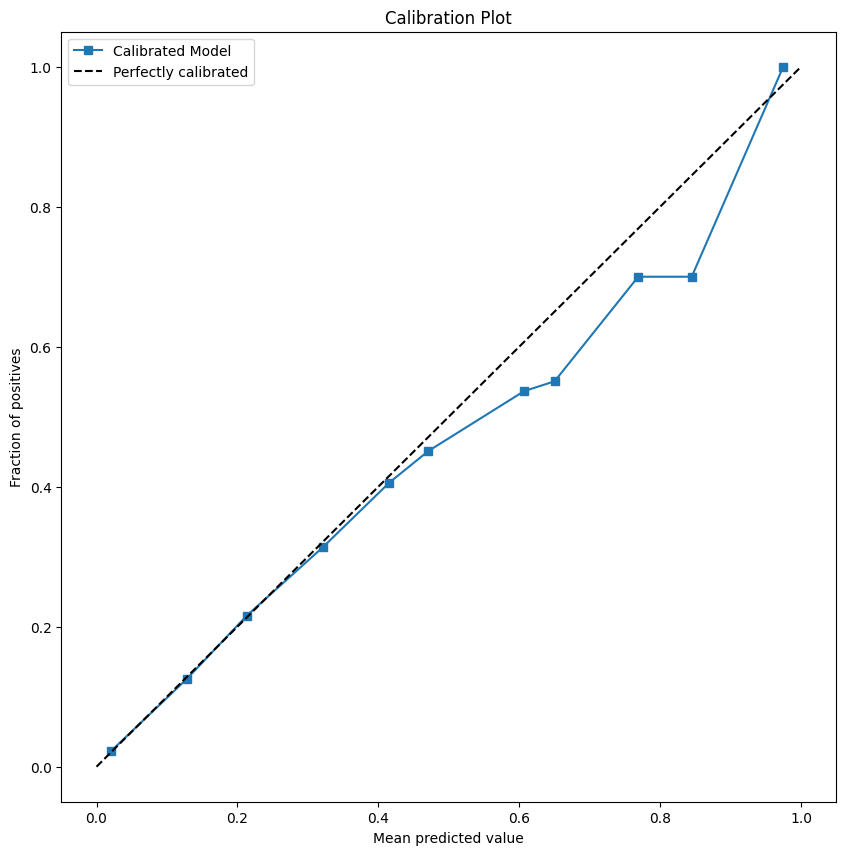

In [36]:
# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, full_test['cali_predics'], n_bins=11)

# Plot calibration curve
plt.figure(figsize=(10, 10))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

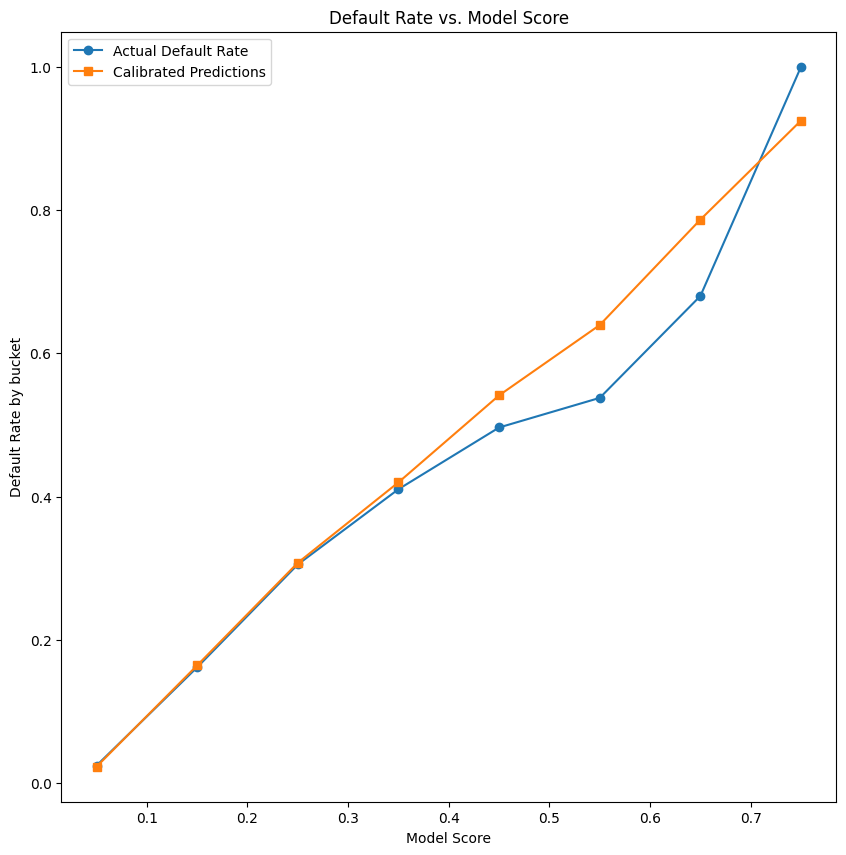

In [37]:
# Assuming `full_test` contains the model scores and `y_test` contains the actual labels
model_scores = full_test['predics']
calibrated_predictions = full_test['cali_predics']

# Binning the data for the actual default rates and calibrated predictions
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

# Initialize arrays to store the default rates
actual_default_rates = np.zeros(n_bins)
calibrated_default_rates = np.zeros(n_bins)
bin_centers = np.zeros(n_bins)

# Calculate the actual and calibrated default rates
for i in range(n_bins):
    bin_mask = (model_scores >= bins[i]) & (model_scores < bins[i + 1])
    bin_centers[i] = (bins[i] + bins[i + 1]) / 2
    actual_default_rates[i] = y_test[bin_mask].mean()
    calibrated_default_rates[i] = calibrated_predictions[bin_mask].mean()

# Plot the default rate curves
plt.figure(figsize=(10, 10))
plt.plot(bin_centers, actual_default_rates, 'o-', label='Actual Default Rate')
plt.plot(bin_centers, calibrated_default_rates, 's-', label='Calibrated Predictions')
plt.xlabel('Model Score')
plt.ylabel('Default Rate by bucket')
plt.title('Default Rate vs. Model Score')
plt.legend()

c:\Users\amr.tawfik\Documents\GitHub\mylo\components\risk-engine\notebooks\utils.py:823: RuntimeWarning: invalid value encountered in subtract
  np.abs(thresholds_test - selected_records[i]).argmin()


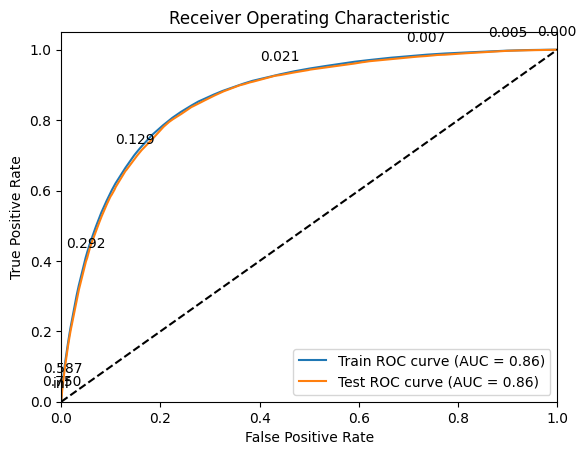

In [38]:
get_roc(y_train, full_train['cali_predics'], y_test, full_test['cali_predics'])
#get_roc(y_train, full_train['cali_predics'], y_test, full_test_neutral['cali_predics'])

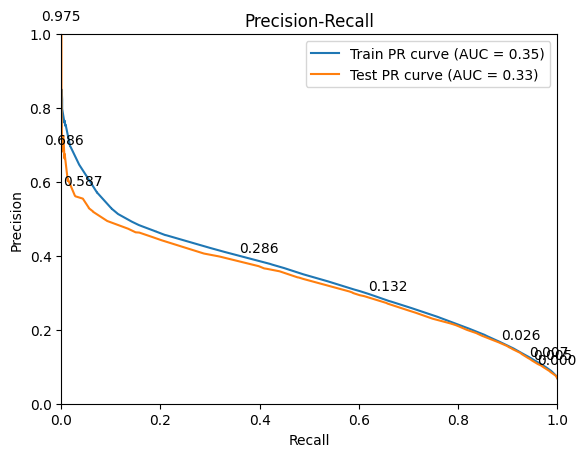

In [39]:
get_PR(y_train, full_train['cali_predics'], y_test, full_test['cali_predics'])
# get_PR(y_train, full_train['cali_predics'], y_test, full_test_neutral['cali_predics'])

In [40]:
def plot_probability_distribution(y_test, predicted_probs, reject_threshold, accept_threshold):
    """
    This function plots the density distributions of predicted probabilities for default and non-default classes.
    
    Parameters:
    y_test (array-like): True labels
    predicted_probs (array-like): Predicted probabilities
    reject_threshold (float): Threshold for rejecting applications
    accept_threshold (float): Threshold for accepting applications
    """
    
    # Convert to DataFrame
    full_test_ = pd.DataFrame({'predics': predicted_probs})

    # Separate probabilities for default (positive) and non-default (negative) classes
    positive_probs = full_test_['predics'][y_test == 1]
    negative_probs = full_test_['predics'][y_test == 0]

    # Plot the density distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(positive_probs, fill=True, color='r', label='Default (Positive Class)')
    sns.kdeplot(negative_probs, fill=True, color='b', label='Non-default (Negative Class)')

    # Determine zones
    #plt.axvline(x=reject_threshold, color='g', linestyle='--', label='Threshold')
    #plt.axvline(x=accept_threshold, color='orange', linestyle='--', label='Threshold')

    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Probability Distribution for Default and Non-default Classes')
    plt.legend()
    plt.show()

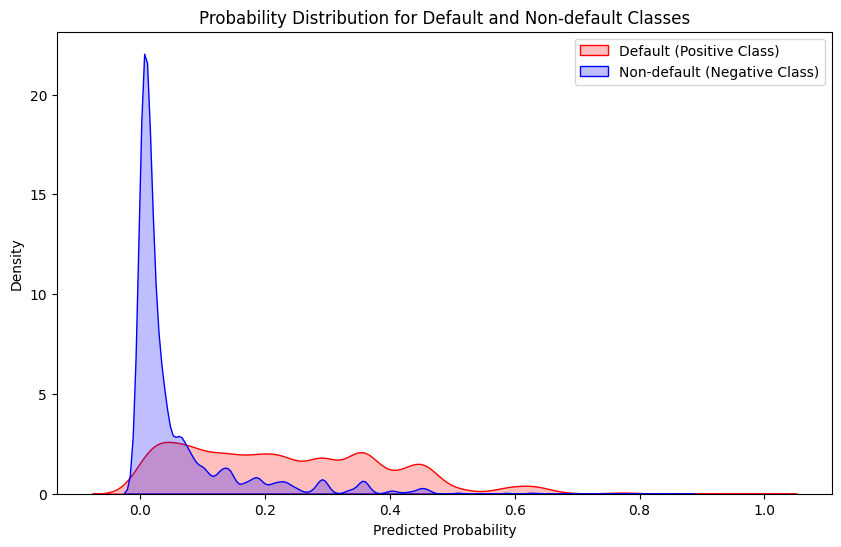

In [41]:
plot_probability_distribution(y_test, full_test['cali_predics'], 0.1, 0.325)
# plot_probability_distribution(y_test, full_test_neutral['cali_predics'], 0.06, 0.04)

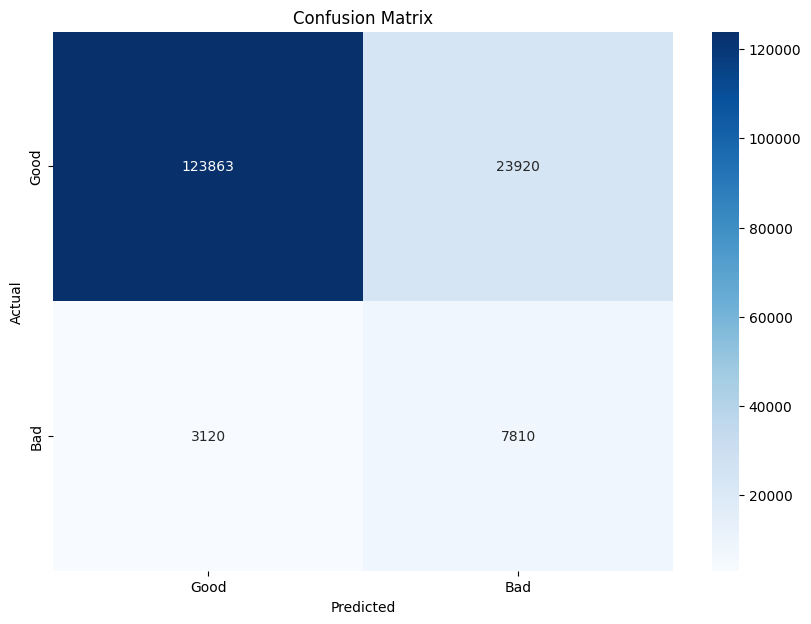

Precision: 24.61%
Recall: 71.45%
Approval rate: 80.01%


In [42]:
calc_class_metrics_iv(y_test, full_test['cali_predics'], score_cutoff=0.1, normalize=False)
#calc_class_metrics_iv(y_test, full_test_neutral['cali_predics'], score_cutoff=0.025, normalize=False)

# 9- Exports

In [43]:
# full_train_ , full_test_ = full_train.copy(), full_test.copy()
# full_train_['pd_dataset'] = 'train_set'
# full_test_['pd_dataset'] = 'test_set'

# df_temp = pd.concat([full_train_, full_test_])[['client_id', 'pd_dataset']].reset_index(drop=True)
# df_temp.to_csv(data_path+'/analytics/pd_model_dataset.csv', index=False)

In [44]:
df_out = pd.concat([full_train, full_test])[['client_id', 'cali_predics']].reset_index(drop=True)

In [45]:
version = 'v0.7'

df_out.to_parquet(data_path / f'models_preds/{data_date}_pd_{version}_predics.parquet')


feature_dtypes = X_test[best_model_lgb.feature_name_].dtypes.to_dict()
feature_names = best_model_lgb.feature_name_

model_and_metadata = {
    'object': best_cali_lgb,
    'features_names': feature_names,
    'features_dtypes': feature_dtypes,
    'explainer': pd_explainer
}

print(f'Saving model to {objects_path}')
joblib.dump(model_and_metadata, objects_path/f"pd_model_{version}.pkl")

Saving model to c:\Users\amr.tawfik\Documents\GitHub\mylo\components\risk-engine\notebooks\objects


['c:\\Users\\amr.tawfik\\Documents\\GitHub\\mylo\\components\\risk-engine\\notebooks\\objects\\pd_model_v0.7.pkl']